In [1]:
import os, shutil
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.transforms.v2.functional as F_v2
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
from Utils.dataset import PreloadedDataset
import matplotlib.pyplot as plt
from tqdm import tqdm

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

from Methods.iGPA.model import iGPA
from Methods.BYOL.model import BYOL
from Methods.AE.model import AE
from Methods.MAE.model import MAE
from Methods.GPAViT.model import GPAViT
from Methods.GPAMAE.model import GPAMAE
from Methods.VAE.model import VAE
from Methods.Supervised.model import Supervised

from Examples.ModelNet10.evals import linear_probing, eval_representations
from Examples.ModelNet10.dataset import ModelNet10
from Utils.functional import get_optimiser
from Utils.train import train

c:\Users\joeag\Documents\venvs\ml-env\Lib\site-packages\torchvision\datapoints\__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
c:\Users\joeag\Documents\venvs\ml-env\Lib\site-packages\torchvision\transforms\v2\__init__.py:54: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
torch.backends.cudnn.benchmark = True
device

'cuda'

In [3]:
root = '../Datasets/'
train_set = ModelNet10(root, 'train', device=torch.device('cpu'))
train_set.data.shape
train_set, val_set = train_set.split_set(0.8)

Loading data...
Loading data...


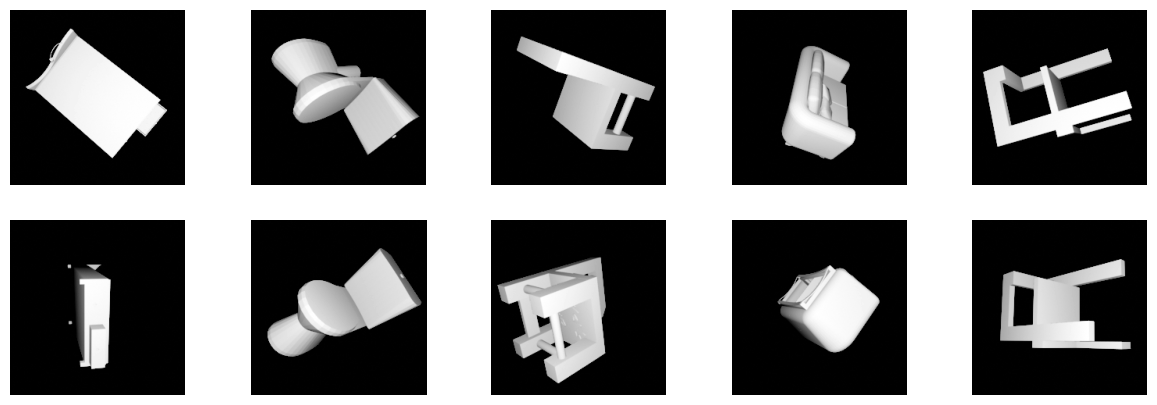

Max value: tensor(222, dtype=torch.uint8)
Min value: tensor(0, dtype=torch.uint8)


In [4]:
fig, axes = plt.subplots(2, 5, figsize=(15,5))
for i, ax in enumerate(axes[0]):
    (img1, rot1, lab1), _ = train_set[i]
    ax.imshow(img1.squeeze().cpu(), cmap='gray')
    ax.axis('off')
for i, ax in enumerate(axes[1]):
    _, (img2, rot2, lab2) = train_set[i]
    ax.imshow(img2.squeeze().cpu(), cmap='gray')
    ax.axis('off')
plt.show()

# print max and min values
print('Max value:', train_set.data.max())
print('Min value:', train_set.data.min())

In [5]:
cfgs = [
    {
        'name': 'AE',
        'model': AE,
        'save': False,
    },
    {
        'name': 'AE',
        'model': AE,
        'save': False,
    },
    {
        'name': 'AE',
        'model': AE,
        'save': False,
    },
    {
        'name': 'AE',
        'model': AE,
        'save': False,
    },
    {
        'name': 'AE',
        'model': AE,
        'save': True,
    },
    {
        'name': 'VAE',
        'model': VAE,
        'save': False,
    },
    {
        'name': 'VAE',
        'model': VAE,
        'save': False,
    },
    {
        'name': 'VAE',
        'model': VAE,
        'save': False,
    },
    {
        'name': 'VAE',
        'model': VAE,
        'save': False,
    },
    {
        'name': 'VAE',
        'model': VAE,
        'save': True,
    },
]

for cfg in cfgs:

    Model = cfg['model']
    backbone = 'resnet18'
    experiment_name = cfg['name']
    # experiment = 'mnist_byol'
    experiment='modelnet10'
    # log_dir = None
    log_dir = f'Examples/ModelNet10/out/logs/{experiment}/{experiment_name}/'
    save_dir = None
    if cfg['save']:
        save_dir = f'Examples/ModelNet10/out/models/{experiment}/{experiment_name}.pth'
    if Model == VAE:
        model = Model(1, 256, backbone=backbone).to(device)
    elif Model == AE or Model == BYOL or Model == MAE:
        model = Model(1, backbone=backbone, decoder='224').to(device)
    else:
        model = Model(1, 5, backbone=backbone).to(device)

    optimiser = get_optimiser(
        model, 
        'AdamW', 
        lr=3e-4, 
        wd=0.004, 
        exclude_bias=True,
        exclude_bn=True,
    )

    to_train = True
    if save_dir is not None:
        try:
            sd = torch.load(save_dir)
            # change keys "project" to "transition"
            for key in list(sd.keys()):
                if 'project' in key:
                    sd[key.replace('project', 'transition')] = sd.pop(key)
            model.load_state_dict(sd)
            to_train = False
            print('Model loaded successfully')
        except FileNotFoundError:
            pass
            print('Model not found, training new model')
    if to_train:
        writer = None
        if log_dir is not None:
            # remove reduction if exists
            if os.path.exists(log_dir + 'encoder/reduction.csv'):
                os.remove(log_dir + 'encoder/reduction.csv')
            if os.path.exists(log_dir + 'classifier/reduction.csv'):
                os.remove(log_dir + 'classifier/reduction.csv')

            run_no = 1
            while os.path.exists(log_dir + 'encoder/' + f'run_{run_no}'):
                run_no += 1
            writer = SummaryWriter(log_dir + 'encoder/' + f'run_{run_no}')
        
        if isinstance(model, iGPA):
            train_set.transform = transforms.Compose([
            ])
            train(
                model,
                optimiser,
                train_set,
                val_set,
                num_epochs=250, 
                batch_size=128,
                dataset='modelnet10',
                has_teacher=True,
                aug_mode='sample',
                augment=None,
                writer=writer,
                save_dir=save_dir,
                save_every=5,
            )
        if isinstance(model, BYOL):
            train_set.transform = transforms.Compose([
            ])
            optimiser = get_optimiser(
                model, 
                'AdamW', 
                lr=3e-5, 
                wd=0.004, 
                exclude_bias=True,
                exclude_bn=True,
            )
            train(
                model,
                optimiser,
                train_set,
                val_set,
                num_epochs=250, 
                batch_size=128,
                dataset='modelnet10',
                has_teacher=True,
                aug_mode='sample',
                augment=None,
                writer=writer,
                save_dir=save_dir,
                save_every=5,
            )
        if isinstance(model, AE):
            train_set.transform = transforms.Compose([
                transforms.RandomAffine(degrees=15, translate=(0.1, 0.1), scale=(0.9, 1.1), shear=10),
            ])
            train(
                model,
                optimiser,
                train_set,
                val_set,
                num_epochs=250, 
                batch_size=128,
                dataset='modelnet10',
                writer=writer,
                save_dir=save_dir,
                save_every=5,
            )
        if isinstance(model, VAE):
            train_set.transform = transforms.Compose([
                transforms.RandomAffine(degrees=15, translate=(0.1, 0.1), scale=(0.9, 1.1), shear=10),
            ])
            train(
                model,
                optimiser,
                train_set,
                val_set,
                num_epochs=250, 
                batch_size=128,
                dataset='modelnet10',
                writer=writer,
                save_dir=save_dir,
                save_every=5,
            )
        if isinstance(model, MAE):
            train_set.transform = transforms.Compose([
                transforms.RandomAffine(degrees=15, translate=(0.1, 0.1), scale=(0.9, 1.1), shear=10),
            ])
            train(
                model,
                optimiser,
                train_set,
                val_set,
                num_epochs=250, 
                batch_size=128,
                dataset='modelnet10',
                writer=writer,
                save_dir=save_dir,
                save_every=5,
            )
        if isinstance(model, Supervised):
            train_set.transform = transforms.Compose([
                transforms.RandomAffine(degrees=30, translate=(0.1, 0.1), scale=(0.9, 1.1), shear=10),
            ])
            train(
                model,
                optimiser,
                train_set,
                val_set,
                num_epochs=250, 
                batch_size=128,
                dataset='modelnet10',
                writer=writer,
                save_dir=save_dir,
                save_every=5,
            )
        
        print(f'Finished training')
        if save_dir is not None:
            print('Run cell again to load best (val_acc) model.')

        # Evaluate inter-neuron correlations
        rep_metrics = eval_representations(model, flatten=False)
        if writer is not None:
            writer.add_scalar('Encoder/test_feature_corr', rep_metrics['corr'])
            writer.add_scalar('Encoder/test_feature_std', rep_metrics['std'])

    # linear probing
    for n in [1, 10, 100, 1000]:
        dest = f'Examples/MNIST/out/logs/n{n}-{experiment}/{experiment_name}/'
        if log_dir is not None:
            writer = SummaryWriter(dest + f'classifier/run_{run_no}')
        linear_probing(model, root, n, writer, flatten=False, test=True)

    # # Semi-supervised learning eval
    # for n in [1, 10, 100, 1000]:
    #     dest = f'Examples/MNIST/out/logs/n{n}-{experiment}/{experiment_name}/'
    #     if log_dir is not None:
    #         writer = SummaryWriter(dest + f'classifier/run_{run_no}')
    #     mnist_linear_eval(model, n, writer, flatten=False, test=True, finetune=True)

Loading data...
Loading data...


TypeError: pic should be PIL Image or ndarray. Got <class 'torch.Tensor'>

In [6]:
from Examples.ModelNet10.dataset import ModelNet10Simple

ss_train_dataset = ModelNet10Simple(root=root, split='train', n=10, transform=transforms.ToTensor(), device=device)
ss_val_dataset = ModelNet10Simple(root=root, split='val', n=10, transform=transforms.ToTensor(), device=device)
ss_train_loader = DataLoader(ss_train_dataset, batch_size=10, shuffle=True)
ss_val_loader = DataLoader(ss_val_dataset, batch_size=1000, shuffle=False)

Loading data...
Loading data...


In [16]:
# for x, y in ss_train_loader:
#     print(x.shape, y.shape)
ss_train_dataset[0]

TypeError: pic should be PIL Image or ndarray. Got <class 'torch.Tensor'>